In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene

import numpy as np
import matplotlib.pyplot as plt
import copy

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
project_colors = {"green": "#58c1ae", "blue": "#0e73b9", "lightgreen": "#cdd451",
                  "babyblue": "#5ebcea", "orange": "#e58033", "yellow": "#eacf5e",
                  "raw": "#ece9d6"}
project_colors_list = ["#58c1ae", "#0e73b9", "#cdd451", "#5ebcea", "#e58033","#eacf5e","#ece9d6"] 

In [4]:
# Do a backup of the data

# Multiply every resource by a factor of 10
# Always check for one dimensional arrays

new_data = copy.deepcopy(data)

'''FACTOR = 10

# Generators
for key in new_data.generator.keys():

    # Check if the array is one dimensional
    # A função tite é pra repetir o elemento new_data.generator[key] por FACTOR vezes
    if len(new_data.generator[key].shape) == 1:
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, ))
    else:
        # Add in n times
        # Se não for uni dimensional, repete factor vezes o array inteiro.
        # Exemplo b = [[1, 2], [3, 4]] -> np.tite(b, (2,1)) => [[1, 2], [3, 4], [1, 2], [3, 4]]
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, 1))

    # Add some noise to the GenActivePower
    if key == 'genActPower':
        new_data.generator[key] = new_data.generator[key] + np.random.normal(0, 0.1, len(new_data.generator[key])) if new_data.generator[key] > 0 else 0

# Loads
for key in new_data.load.keys():

    # Check if the array is one dimensional
    if len(new_data.load[key].shape) == 1:
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, 1))

    # Add some noise to the LoadActivePower
    if key == 'loadActPower':
        new_data.load[key] = new_data.load[key] + np.random.normal(0, 0.1, len(new_data.load[key])) if new_data.load[key] > 0 else 0

# Storages
for key in new_data.storage.keys():

    # Check if the array is one dimensional
    if len(new_data.storage[key].shape) == 1:
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, 1))

# EVs
for key in new_data.vehicle.keys():

    # Check if the array is one dimensional
    if len(new_data.vehicle[key].shape) == 1:
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, 1))

# Increase the import and export maximum values by a factor of 10 to keep up
new_data.peers['import_contracted_p_max'] = new_data.peers['import_contracted_p_max'] * 10
new_data.peers['export_contracted_p_max'] = new_data.peers['export_contracted_p_max'] * 10'''

# Do a backup of the data
data_backup = copy.deepcopy(data)

# Assign the new data to original data
data = copy.deepcopy(new_data)

In [5]:
new_data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [6]:
# Define generators
gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

gens.to_json(path="./input_data")

# Define loads
loads = Load(name='loads',
             value=data.load['p_forecast'],
             lower_bound=np.zeros(data.load['p_forecast'].shape),
             upper_bound=data.load['p_forecast'],
             cost=np.ones(data.load['p_forecast'].shape),
             cost_cut=data.load['cost_cut'],
             cost_reduce=data.load['cost_reduce'],
             cost_ens=data.load['cost_ens'])

loads.to_json(path="./input_data")

# Define storage
stor = Storage(name='stor',
               value=np.zeros(data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(data.storage['p_charge_limit'].shape),
               upper_bound=(data.storage['energy_capacity'] *
                            np.ones(data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(data.storage['p_charge_limit'].shape),
               cost_discharge=data.storage['discharge_price'],
               cost_charge=data.storage['charge_price'],
               capacity_max=data.storage['energy_capacity'],
               capacity_min=data.storage['energy_min_percentage'],
               initial_charge=data.storage['initial_state'],
               discharge_efficiency=data.storage['discharge_efficiency'],
               discharge_max=data.storage['p_discharge_limit'],
               charge_efficiency=data.storage['charge_efficiency'],
               charge_max=data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               capital_cost=np.array([0.05250, 0.10500, 0.01575]))
stor.to_json(path="./input_data")

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(data.vehicle['schedule_charge'].shape),
              lower_bound=(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc'] *
                           np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(data.vehicle['e_capacity_max'] * np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(data.vehicle['schedule_charge'].shape),
              cost_discharge=data.vehicle['discharge_price'][:, 0],
              cost_charge=data.vehicle['charge_price'][:, 0],
              capacity_max=data.vehicle['e_capacity_max'],
              initial_charge=np.ones(data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=data.vehicle['min_technical_soc'],
              discharge_efficiency=data.vehicle['discharge_efficiency'],
              charge_efficiency=data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063]),
              schedule_discharge=data.vehicle['schedule_discharge'],
              schedule_charge=data.vehicle['schedule_charge'])
v2g.to_json(path="./input_data")

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['import_contracted_p_max'][0, :],
                      cost=data.peers['buy_price'][0, :],
                      is_active=np.zeros(data.peers['import_contracted_p_max'][0, :].shape))
pimp.to_json(path="./input_data")

pexp = BinaryResource(name='pExp',
                      value=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['export_contracted_p_max'][0, :],
                      cost=data.peers['sell_price'][0, :],
                      is_active=np.zeros(data.peers['export_contracted_p_max'][0, :].shape))
pexp.to_json(path="./input_data")

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [7]:
# Create the scene

#@TODO O ERRO ESTÁ QUE O ORIGINAL TEM 3 CS. ELE MULTUPLICAVA TUDO POR 30. AGORA ELE RECLAMA:
#operands could not be broadcast together with shapes (30,24) (3,24) -> x['v2gDchActPower'] * self.v2g_discharge_cost +
scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene.initialize()
scene.run()


Olá, voce está na func run e esse é o self.algo.population: 
 [[ 0.          0.          0.         ...  7.65228289  6.00907689
   4.116725  ]
 [ 0.          0.          0.         ...  3.93755699  4.47856159
  10.74958051]
 [ 0.          0.          0.         ...  1.33816505  1.59100029
   8.71372609]
 ...
 [ 0.          0.          0.         ...  2.10584975  7.17098803
   4.65300974]
 [ 0.          0.          0.         ...  4.51303885  4.18031872
  10.84037646]
 [ 0.          0.          0.         ...  2.59047691  6.49387156
   9.9037189 ]]

 opa, self.algo.population.shape[0]:  20


100%|██████████| 10000/10000 [11:08<00:00, 14.96it/s]


After running the scene, saving all the variables again to see if anything has changed.

In [8]:
gens.to_json(path="./after_opt_input_data")
loads.to_json(path="./after_opt_input_data")
stor.to_json(path="./after_opt_input_data")
v2g.to_json(path="./after_opt_input_data")
pimp.to_json(path="./after_opt_input_data")
pexp.to_json(path="./after_opt_input_data")

In [9]:
scene.to_json(path="./results", filename="scene_results")

In [10]:
#scene.components['evs'].capital_cost
v2g.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06], dtype=object)

In [11]:
# Sum matrices along the columns

scene.algo.population_fitness

[220.91559406331012,
 221.20590164747108,
 221.12782690854837,
 220.80352252619582,
 220.80483088788964,
 221.16789202253497,
 221.15501968518072,
 220.94246770289212,
 220.91412960826023,
 220.81309930686515,
 220.8493427701826,
 220.93786922637364,
 220.9603936834963,
 221.1202735152826,
 220.80710910347565,
 220.99118014715367,
 221.9231723950196,
 221.0100945811879,
 220.91471386414617,
 221.1292494593175]

In [12]:
 # Check the population

scene.algo.population

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [13]:
scene.current_best

{'genActPower': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.49926224,  1.44075834,  3.39238015,  5.74045366,  7.57249838,
          8.7591679 ,  9.41482764,  9.37168229,  8.61888136,  7.44052468,
          5.62772342,  3.16556251,  1.32649245,  0.46616505,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [10.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , 10.        ,  0.        ,
         10.        ,  0.        ,  0.        ,

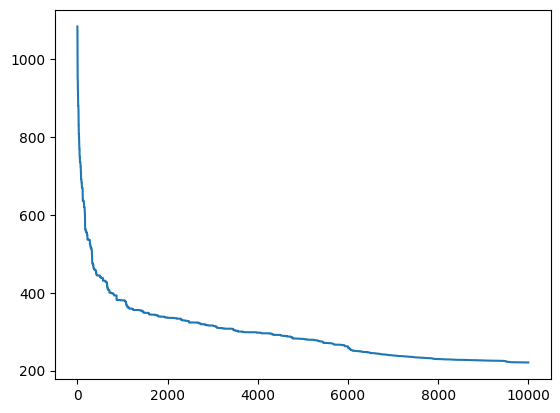

In [14]:
plt.plot(scene.algo.population_history_fitness)

In [15]:
scene.algo.population_history_fitness

[1083.709105491457,
 1068.049670595559,
 1040.9260611346224,
 1024.162383552752,
 973.9434101667197,
 973.9434101667197,
 953.2415283139054,
 948.3525506715896,
 948.3525506715896,
 915.8591851856087,
 915.8591851856087,
 915.8591851856087,
 915.8591851856087,
 915.8591851856087,
 915.8591851856087,
 881.1648997199603,
 881.1648997199603,
 881.1648997199603,
 881.1648997199603,
 881.1648997199603,
 881.1648997199603,
 881.1648997199603,
 875.1159598675933,
 875.1159598675933,
 875.1159598675933,
 863.7129167577775,
 829.7683969973256,
 829.7683969973256,
 829.7683969973256,
 829.7683969973256,
 806.1244132655768,
 806.1244132655768,
 806.1244132655768,
 806.1244132655768,
 806.1244132655768,
 803.5060973114148,
 803.5060973114148,
 794.6897296986042,
 794.6897296986042,
 790.0913219621701,
 777.4275590664331,
 777.4275590664331,
 777.4275590664331,
 770.25415112247,
 770.25415112247,
 770.25415112247,
 770.25415112247,
 770.25415112247,
 749.1276292382272,
 749.1276292382272,
 749.1276

In [16]:
scene.algo.population_fitness

[220.91559406331012,
 221.20590164747108,
 221.12782690854837,
 220.80352252619582,
 220.80483088788964,
 221.16789202253497,
 221.15501968518072,
 220.94246770289212,
 220.91412960826023,
 220.81309930686515,
 220.8493427701826,
 220.93786922637364,
 220.9603936834963,
 221.1202735152826,
 220.80710910347565,
 220.99118014715367,
 221.9231723950196,
 221.0100945811879,
 220.91471386414617,
 221.1292494593175]

In [17]:
scene.current_best_fitness

220.98255783690277